<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Prediction

---
    Mubina | Wei Hua | Liubin    

In this notebook, We will conduct exploratory analysis over train, spray and weather data to find interesting insights. 

## Contents:
- [1. Import Libraries](#1.-Import-Libraries)
- [2. Load Data](#2.-Load-Data)
- [3. EDA](#3.-EDA)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import time
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
import folium
from branca.element import Figure
from folium.plugins import MarkerCluster

from sklearn.neighbors import KernelDensity

%matplotlib inline
#sns.set_style("darkgrid")
sns.set_palette("viridis")

## 2. Load Data

In [2]:
data_path = "../assets/"

train = pd.read_csv(data_path + "train_cleaned.csv")
weather = pd.read_csv(data_path + "weather_cleaned.csv")
spray = pd.read_csv(data_path + "spray_cleaned.csv")
test = pd.read_csv(data_path + "test.csv")
mapdata = np.loadtxt(data_path + "mapdata_copyright_openstreetmap_contributors.txt")

## 3. EDA

### 3.1 EDA on train trap data
This is the data associated with each mosquito trap deployed across the city of Chicago. The location of the traps are described by the block number and street name which have been conveniently mapped into Latitude and Longitude.

The trap data was collected among years: 2007, 2009, 2011 & 2013.

In [3]:
train["date"] = pd.to_datetime(train["date"], format='%Y-%m-%d')

In [4]:
train.date.dt.year.value_counts()

2007    2775
2013    2012
2009    1915
2011    1773
Name: date, dtype: int64

In [5]:
train.head(2)

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,day,nearest_station
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,2007,5,29,2
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,2007,5,29,2


In [6]:
train.shape

(8475, 16)

In [7]:
train.wnvpresent.value_counts(normalize=True)

0    0.946077
1    0.053923
Name: wnvpresent, dtype: float64

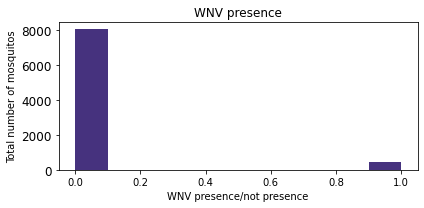

In [8]:
plt.figure(figsize=(6,3))
plt.hist(train.wnvpresent)
plt.title('WNV presence', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('WNV presence/not presence')
plt.ylabel('Total number of mosquitos')
plt.tight_layout()

#### Comments:
- We can see that about 95% train data with no WNV present, while only 5% with WNV present. 
- It's a highly umbalanced dataset, when comes to model part We need to apply resampling on train data, for example, SMOTE provided by the imblanced-learned python library in the SMOTE class.

### 3.2 Mosquito species

In [9]:
# what species are there
print(f'number of species: {train["species"].nunique()}')
train["species"].value_counts(normalize=True)

number of species: 7


CULEX PIPIENS/RESTUANS    0.451445
CULEX RESTUANS            0.282360
CULEX PIPIENS             0.230088
CULEX TERRITANS           0.025487
CULEX SALINARIUS          0.009794
CULEX TARSALIS            0.000708
CULEX ERRATICUS           0.000118
Name: species, dtype: float64

Text(0.5, 1.0, 'total number of samples collected for each species')

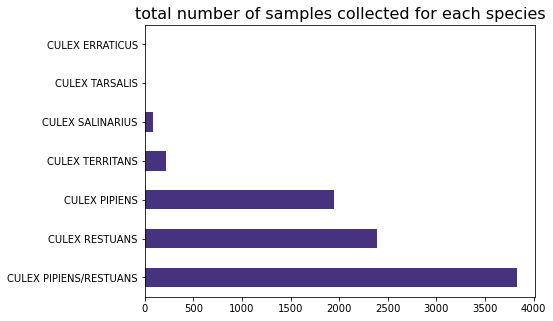

In [10]:
train['species'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('total number of samples collected for each species', fontsize=16)

                        nummosquitos  wnvpresent
species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         184
CULEX PIPIENS/RESTUANS         66268         225
CULEX RESTUANS                 23431          48
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0


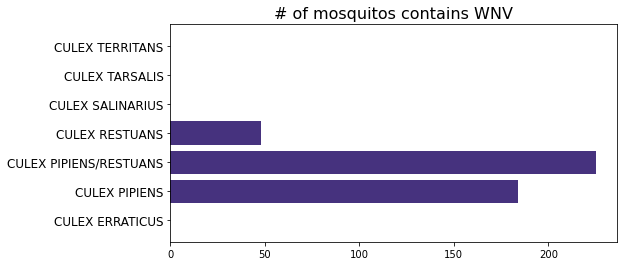

In [11]:
mos_present= train[["species","nummosquitos","wnvpresent"]].groupby(by="species").sum()
print(mos_present)
mos_present.reset_index(inplace=True)
plt.figure(figsize=(8,4))
plt.barh(mos_present.species, mos_present.wnvpresent)
plt.title("# of mosquitos contains WNV", fontsize =16)
plt.yticks(fontsize=12)
plt.show()

#### Comments:
- Top 3 species mosquitos are: CULEX PIPIENS/RESTUANS, CULEX RESTUANS and CULEX PIPIENS which made up more than 96% of the sample of the species sampled
- Theres top 3 species mosquitos also and only been detected with WNV presents.

### 3.3 Traps check

In [12]:
train.trap.nunique()

136

In [13]:
train.trap.value_counts()

T900     154
T002     147
T135     147
T115     143
T151     143
        ... 
T078       6
T076       5
T094B      5
T237       3
T040       2
Name: trap, Length: 136, dtype: int64

     trap  wnvpresent
134  T900          29
1    T002          15
82   T115          15
2    T003          14
121  T225          11
9    T011          11
11   T013          10
86   T138           9
20   T028           9
81   T114           9


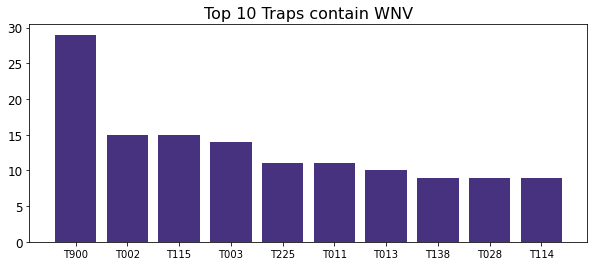

In [14]:
trap_present=train[['trap', 'wnvpresent']].groupby(by="trap").sum()
trap_present.reset_index(inplace=True)
trap_present.sort_values(by='wnvpresent', ascending=False, inplace=True)
trap_present=trap_present[:10]
print(trap_present)

plt.figure(figsize=(10,4))
plt.bar(trap_present.trap, trap_present.wnvpresent)
plt.title("Top 10 Traps contain WNV", fontsize =16)
plt.yticks(fontsize=12)
plt.show()

#### Comments:
- There are 136 traps in the train data and trap no. T900(at Ohare airport) has the most sampled data.
- The top 10 traps with WNV presence 
     - T900          29
     - T002          15
     - T115          15
     - T003          14
     - T225          11
     - T011          11
     - T013          10
     - T138           9
     - T028           9
     - T114           9

There are the address, latitude & longitude for all traps in train data, we will see how to associate with Spray or Weather data to get more insights on the traps to understand whether there are any spray been done or monitoring locations made near the traps.  

### 3.4 WNVPresent Correlation

<AxesSubplot:>

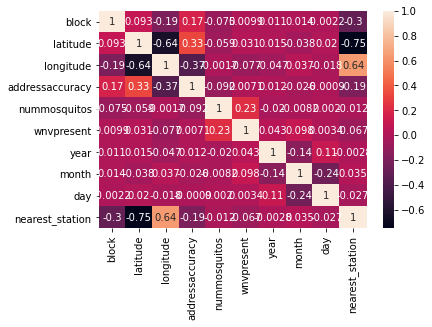

In [15]:
# To find out the correlation between variables in train dataset
sns.heatmap(train.corr(), annot=True)

In [16]:
# To find out the correlation between number of mosquitos and wnvpresent
train.corr()['wnvpresent'].sort_values(ascending=False)

wnvpresent         1.000000
nummosquitos       0.233532
month              0.097948
year               0.043038
latitude           0.030862
block              0.009859
addressaccuracy    0.007057
day                0.003400
nearest_station   -0.066947
longitude         -0.076732
Name: wnvpresent, dtype: float64

#### Comments:
- The top 3 important factors are year, month and number of mosquitoes to the WNV present. 
- We will plot out the WNV present for these 3 factors to get a close look on their distribution and relationship.

C:\Users\liubin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\liubin\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


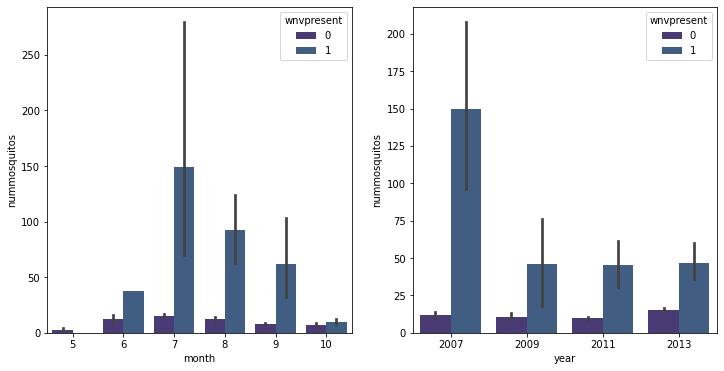

In [17]:
plt.subplots(figsize=(12,6))
plt.subplot(1,2,1),sns.barplot('month','nummosquitos',data=train,hue='wnvpresent')  #,fit_reg=False
i=plt.subplot(1,2,2),sns.barplot('year','nummosquitos',data=train,hue='wnvpresent')  #,fit_reg=False

#### Comments:

- There is the highest amount of mosquitos in Jun and reduced as the summer progresses. 
- There is the highest amount of mosquitos in year 2007, probably it's the hottest years. 
- It was observed that there were more mosquitoes in the summer (Jul to August).
- With the higher number of mosquitoes, the number of wnvpresent is also higher.

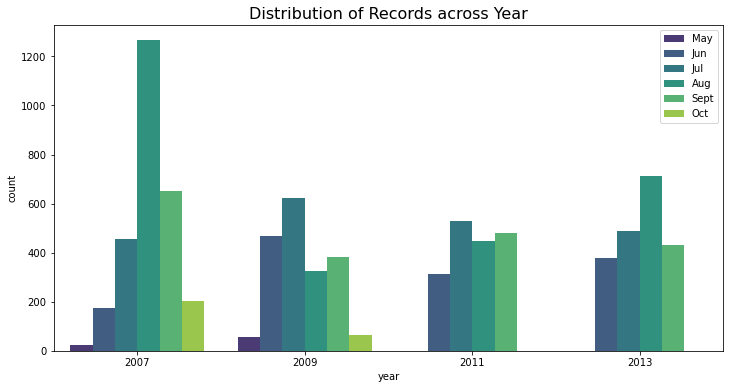

In [18]:
plt.figure(figsize=[12,6])

sns.countplot(data=train, x="year", hue="month")

plt.title("Distribution of Records across Year", size=16)
plt.legend(["May", "Jun", "Jul", "Aug", "Sept", "Oct"], loc=1)

plt.show()

#### Comments:

- Jul, Aug were the months where most records come from in 2007 & 2013 and 2009 & 2011 respectively
- Most records come from Aug in 2007
- Records increased when it came to summer and descreased when it went to after summer seasons

### 3.5 Spray & Train trap locations

In [19]:
spray["date"] = pd.to_datetime(spray["date"], format='%Y-%m-%d')

Text(0, 0.5, 'Latitude')

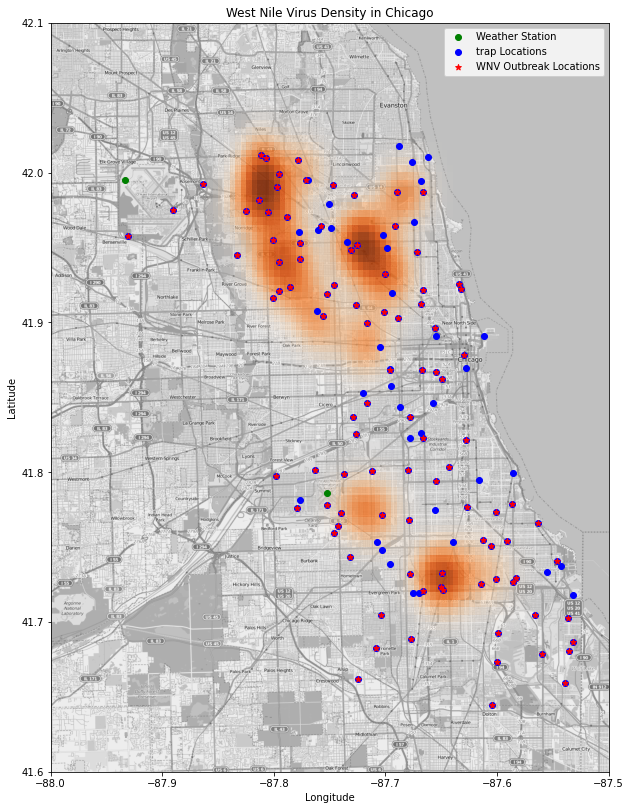

In [20]:
# Check spray area via map
alpha_cm = plt.cm.Oranges
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
X = spray[['longitude', 'latitude']].drop_duplicates().values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

# Weather Station locations
plt.scatter(x = (-87.933, -87.752), y = (41.995, 41.786), marker='o', color='g', label='Weather Station')

# trap locations
trap_locations = train[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='trap Locations')

# wnn outbreak locations
wnv_locations = train[train['wnvpresent'] != 0][['longitude', 'latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('West Nile Virus Density in Chicago')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

This is the map to visualise the following :

- Green circles are where the weather stations located
- Blue circles indicate the location of the traps placed for catching mosquitoes
- Red stars indicate the location of the WNV outbreak and the orange markings describe the areas that were sprayed.
- Area with the darker orange indicates that the region has more spray concentration area and the area with lighter red means that less spray concentration area.

### Comments:

- the traps are pretty spread out
- spray didn't covered most of the WNV outbreak area

### 3.6 Probability of WNV by num of mosquitos

Text(0.5, 1.0, 'Probability of WNV by num of mosquitos')

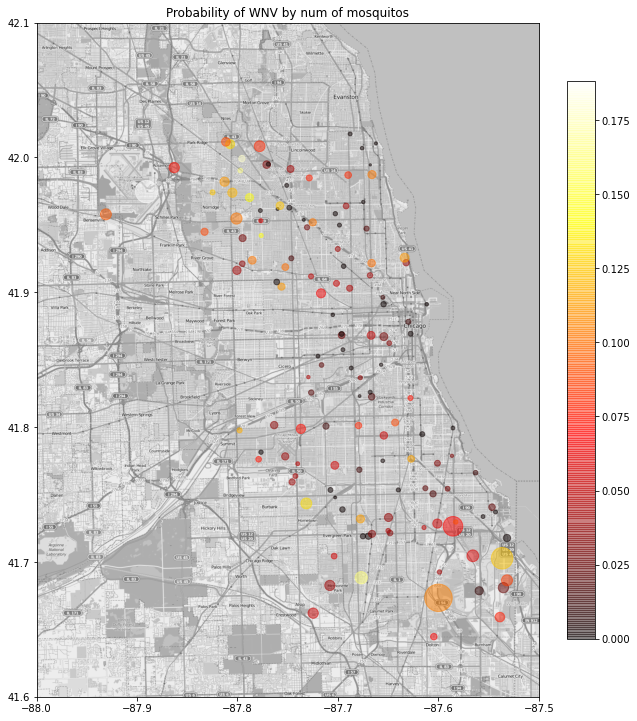

In [21]:
trainll = train.groupby(['latitude', 'longitude'],as_index=False).mean().copy()
traps = train[['date', 'trap','longitude', 'latitude', 'wnvpresent']]

# mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

locations = traps[['longitude', 'latitude']].drop_duplicates().values
#plt.scatter(locations[:,0], locations[:,1], marker='x')
plt.scatter(trainll['longitude'], trainll['latitude'], c=trainll.wnvpresent, s=5*trainll.nummosquitos, 
            marker='o',alpha=0.5, cmap='hot')
plt.colorbar(fraction=0.05)
plt.title('Probability of WNV by num of mosquitos')

### 3.7 Weather Data Inspection and EDA

In [22]:
weather.head()

,index,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,...,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day
0,0,1,2007-05-01,83,50,67,51,56,0,2,...,,0.00,29.10,29.82,1.7,27,9.2,2007,5,1
1,1,2,2007-05-01,84,52,68,51,57,0,3,...,,0.00,29.18,29.82,2.7,25,9.6,2007,5,1
2,2,1,2007-05-02,59,42,51,42,47,14,0,...,BR,0.00,29.38,30.09,13.0,4,13.4,2007,5,2
3,3,2,2007-05-02,60,43,52,42,47,13,0,...,BR HZ,0.00,29.44,30.08,13.3,2,13.4,2007,5,2
4,4,1,2007-05-03,66,46,56,40,48,9,0,...,,0.00,29.39,30.12,11.7,7,11.9,2007,5,3


In [23]:
weather.dtypes

index            int64
station          int64
date            object
tmax             int64
tmin             int64
tavg             int64
dewpoint         int64
wetbulb          int64
heat             int64
cool             int64
sunrise         object
sunset          object
codesum         object
preciptotal     object
stnpressure    float64
sealevel       float64
resultspeed    float64
resultdir        int64
avgspeed       float64
year             int64
month            int64
day              int64
dtype: object

In [24]:
weather["date"] = pd.to_datetime(weather["date"], format='%Y-%m-%d')

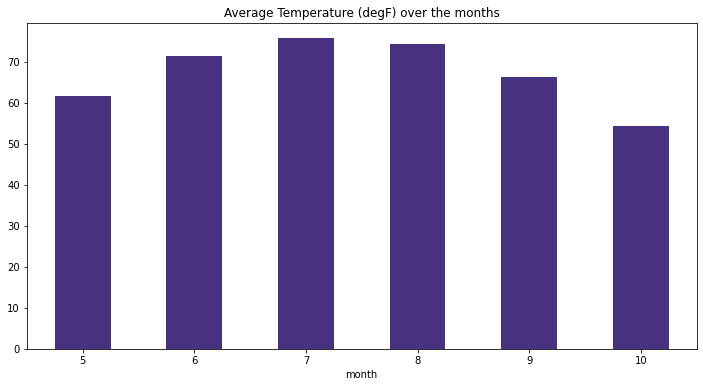

In [25]:
plt.figure(figsize=(12,6))
weather.groupby(by="month")['tavg'].mean().plot(kind='bar')
plt.xticks(rotation = 0)
plt.title("Average Temperature (degF) over the months", fontsize =12)
plt.show();

#### Comments:
- June to August have the highest average temperature as compared to the other months of the year.

In [26]:
X = weather.year.unique()
X

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], dtype=int64)

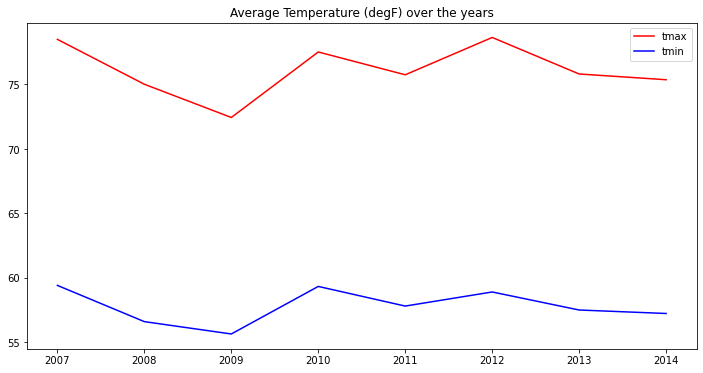

In [27]:
plt.figure(figsize=(12,6))
X = weather.year.unique()
y1= weather.groupby(by="year")['tmax'].mean()
y2= weather.groupby(by="year")['tmin'].mean()
plt.plot(X,y1,label='tmax',color='r')
plt.plot(X,y2,label='tmin',color='b')
plt.xticks(rotation = 0)
plt.title("Average Temperature (degF) over the years", fontsize =12)
plt.legend()
plt.show();

In [28]:
weather.wetbulb.unique()

array([56, 57, 47, 48, 50, 49, 46, 54, 53, 62, 63, 60, 61, 51, 59, 58, 43,
       44, 45, 65, 66, 67, 64, 52, 55, 69, 68, 70, 72, 71, 73, 74, 76, 42,
       39, 40, 41, 35, 33, 34, 75, 36, 32, 38, 78, 77, 37], dtype=int64)

In [29]:
weather.columns

Index(['index', 'station', 'date', 'tmax', 'tmin', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'year', 'month', 'day'],
      dtype='object')

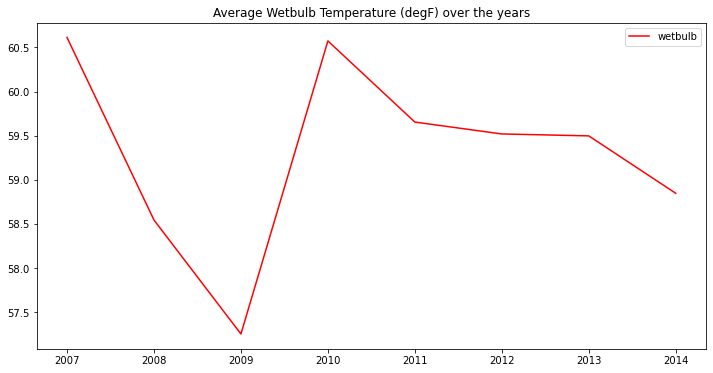

In [30]:
plt.figure(figsize=(12,6))
X = weather.year.unique()
y1= weather.groupby(by="year")['wetbulb'].mean()
plt.plot(X,y1,label='wetbulb',color='r')
plt.xticks(rotation = 0)
plt.title("Average Wetbulb Temperature (degF) over the years", fontsize =12)
plt.legend()
plt.show();

#### Comments:

- 2009 has the lowest average wetbulb temperature, lowest tmax and tmin over the years of 2007 to 2014.
- A lower wet bulb temperature means the air is drier.
- Previously in the train data, it showed that 2009 have the lowest amount of mosquitoes and wnvpresent.


- 2007 and 2012 have the highest tmax.
- 2007 and 2010 have the highest average wetbulb temperature.
- In the previous train data, it also showed that 2007 have the highest amount of moqsuitoes.


We can conclude that there is more mosquitoes in high temperature and high humidity. High amount of mosquitoes increase the probability of west nile virus present in Chicago.

### 3.8 To understand the correlation between Train data and Weather data

In [31]:
df=weather.merge(train,on=['date','year','month'])

In [32]:
df.head()

,index,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,...,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,day_y,nearest_station
0,56,1,2007-05-29,88,60,74,58,65,0,9,...,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,29,2
1,56,1,2007-05-29,88,60,74,58,65,0,9,...,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,29,2
2,56,1,2007-05-29,88,60,74,58,65,0,9,...,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,1,0,29,2
3,56,1,2007-05-29,88,60,74,58,65,0,9,...,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0,29,2
4,56,1,2007-05-29,88,60,74,58,65,0,9,...,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,1,0,29,2


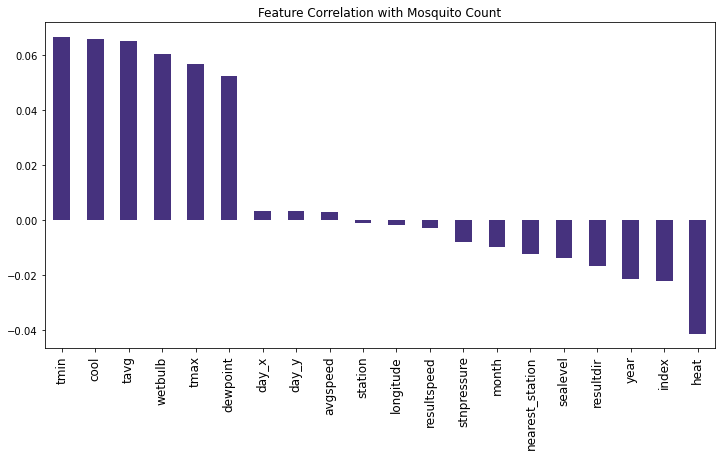

In [33]:
fig = plt.figure(figsize=(12,6))
df.drop(['wnvpresent', 'addressaccuracy','block', 'latitude'], 
        axis=1).corr()['nummosquitos'].sort_values(ascending=False)[1:].plot(kind='bar')
plt.title("Feature Correlation with Mosquito Count")
plt.xticks(size = 12);

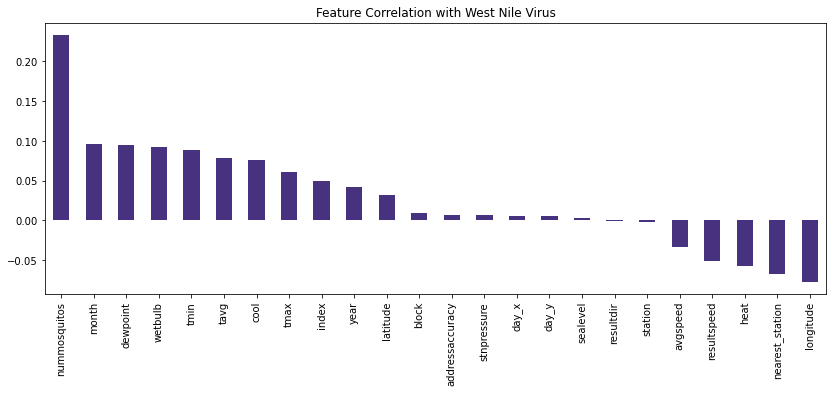

In [34]:
fig = plt.figure(figsize=(14,5))
df.corr()['wnvpresent'].sort_values(ascending=False)[1:].plot(kind='bar')
plt.title("Feature Correlation with West Nile Virus")
plt.xticks(size = 10);

Below we will study the location which has the virus's presence.

Firstly, we will group the locations with the virus's presence, then create a map with markers indicating the areas. The map will include the weather stations which were used to study the weather data.

In [35]:
#Grouping of virus location
wnv_present = train.loc[train['wnvpresent'] > 0 ,['latitude','longitude']]
wnv_present.head()

,latitude,longitude
464,41.686398,-87.531635
569,41.673408,-87.599862
570,41.673408,-87.599862
710,41.688324,-87.676709
718,41.731922,-87.677512


In [36]:
#Turning dataframe to list for plotting of locations
wnv_present_list = wnv_present.values.tolist()

In [37]:
#Location of the presence of virus
fig = Figure(width=850, height=550)
m = folium.Map(location=[41.9, -87.7], zoom_start=10, min_zoom=10, max_zoom=15, tiles='cartodbdark_matter')
fig.add_child(m)

marker_cluster = MarkerCluster().add_to(m)

#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT (Red Marker)
folium.Marker(location=[41.995, -87.933],popup='Custom Marker 1',tooltip='<strong>Weather Station 1</strong>',
              icon=folium.Icon(color='red',icon='none')).add_to(m)
#Station 2: CHICAGO MIDWAY INTL ARPT (Blue Marker)
folium.Marker(location=[41.786, -87.752],popup='Custom Marker 2',tooltip='<strong>Weather Station 2</strong>',
              icon=folium.Icon(color='blue',icon='none')).add_to(m)

for lat_long in wnv_present_list:
    folium.CircleMarker(lat_long, radius=2).add_to(marker_cluster)
    
m